In [9]:
import pandas_datareader as pdr
import pandas as pd

In [10]:
df=pdr.get_data_tiingo('AAPL',api_key='dd9a666434d41a509c66f40143ae2bd85335293c')

/home/l/.local/lib/python3.8/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [11]:
df.to_csv('AAPL.csv')

In [12]:
df=pd.read_csv('AAPL.csv')

In [13]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-10-28 00:00:00+00:00,113.72,115.21,113.45,113.87,37861662,26.657990,27.007273,26.594697,26.693153,151446648,0.00,1.0
1,AAPL,2016-10-31 00:00:00+00:00,113.54,114.23,113.20,113.65,26419398,26.615795,26.777543,26.536093,26.641581,105677592,0.00,1.0
2,AAPL,2016-11-01 00:00:00+00:00,111.49,113.77,110.53,113.46,43825812,26.135238,26.669711,25.910197,26.597041,175303248,0.00,1.0
3,AAPL,2016-11-02 00:00:00+00:00,111.59,112.35,111.23,111.40,28331709,26.158680,26.336838,26.074290,26.114141,113326836,0.00,1.0
4,AAPL,2016-11-03 00:00:00+00:00,109.83,111.46,109.55,110.98,26932602,25.879723,26.263807,25.813745,26.150703,107730408,0.57,1.0


In [14]:
df1=df.reset_index()['close']

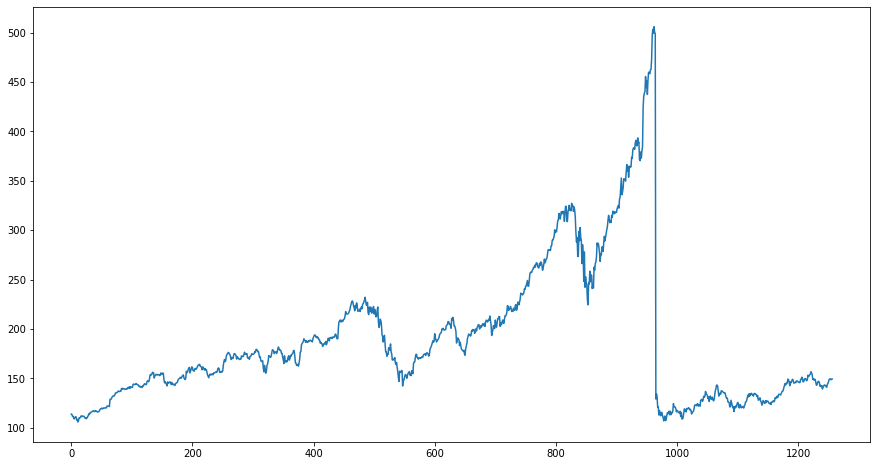

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(df1)

In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
train_data=df1[:int(len(df1)*0.65)]
test_data=df1[int(len(df1)*0.65):]

TimeSteps: assuming data (100 120 130 140 150)    
if we take timesteps=3  
then we will be having 3 features (f1->100,f2->120,f3->130, o/p->140)  
taking three features at a time and predicting output  
X_train...................y_train  
f1....f2....f3.............op  
100...120...130.....140  
120...130...140.....150


In [19]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0] 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [20]:
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [21]:
X_train.shape,y_train.shape

((716, 100), (716,))

In [147]:
# For LSTM we need data as [samples,time steps,features]
X_train=X_train.reshape(X_train.shape[0],-1,1)
X_test=X_test.reshape(X_test.shape[0],-1,1)

In [148]:
X_train.shape

(715, 100, 1)

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

In [150]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [151]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
12/12 [==============================] - 9s 291ms/step - loss: 0.0138 - val_loss: 0.0325
Epoch 2/10
12/12 [==============================] - 2s 182ms/step - loss: 0.0042 - val_loss: 0.0264
Epoch 3/10
12/12 [==============================] - 2s 156ms/step - loss: 0.0019 - val_loss: 0.0216
Epoch 4/10
12/12 [==============================] - 2s 160ms/step - loss: 9.4207e-04 - val_loss: 0.0224
Epoch 5/10
12/12 [==============================] - 2s 145ms/step - loss: 6.2817e-04 - val_loss: 0.0259
Epoch 6/10
12/12 [==============================] - 2s 146ms/step - loss: 5.4375e-04 - val_loss: 0.0250
Epoch 7/10
12/12 [==============================] - 2s 144ms/step - loss: 5.1027e-04 - val_loss: 0.0244
Epoch 8/10
12/12 [==============================] - 2s 144ms/step - loss: 4.7997e-04 - val_loss: 0.0254
Epoch 9/10
12/12 [==============================] - 2s 154ms/step - loss: 4.8268e-04 - val_loss: 0.0244
Epoch 10/10
12/12 [==============================] - 2s 161ms/step - loss: 4

In [153]:
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)

In [154]:
train_pred=scaler.inverse_transform(train_pred)
test_pred=scaler.inverse_transform(test_pred)

In [155]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train,train_pred))

185.8617263996077


In [156]:
mean_absolute_error(y_test,test_pred)

187.40499757305176

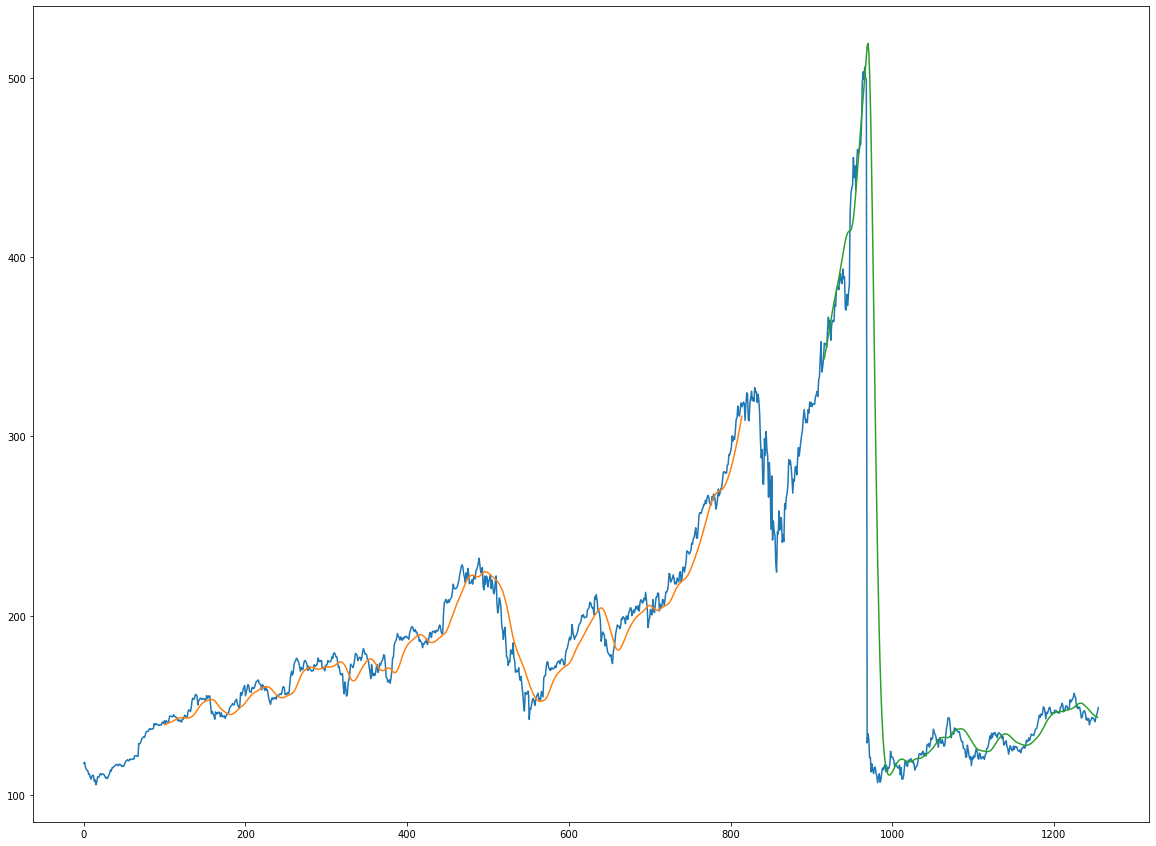

In [159]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df1)-1] = test_pred
plt.figure(figsize=(20,15))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()